# 0.0. IMPORTS

In [1]:
pip install boruta

In [2]:
pip install kneed

In [3]:
pip install inflection

In [4]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats
import xgboost             as xgb
import plotly.express      as px

import pickle
import datetime
import warnings
import random
import json
import requests
import inflection

from IPython.display           import HTML,display,IFrame,Image
from tabulate                  import tabulate
from kneed                     import KneeLocator
from boruta                    import BorutaPy
from sklearn                   import metrics
from sklearn.ensemble          import RandomForestRegressor,ExtraTreesRegressor
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection   import train_test_split
from sklearn.linear_model      import LinearRegression,Lasso,Ridge,LinearRegression
from sklearn.metrics           import mean_absolute_error,mean_squared_error

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.1 Helper Functions

In [5]:
def delete_outliers(data,serie):

  number_of_lines=data.shape[0]  

  for i in range(0,len(serie)):
    md=data[serie[i]].mean()
    standard_deviation=data[serie[i]].std()

    data['ZScore']=(data[serie[i]]-md)/standard_deviation
    data['ZScore']=np.abs(data['ZScore'])

    data=data[data['ZScore']<3]
    data=data.drop(['ZScore'],axis=1)

  number_of_current_lines=data.shape[0]
  deleted_lines=number_of_lines-number_of_current_lines

  return data,deleted_lines


def cramer_v(x,y):
  cm=pd.crosstab(x,y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
  

def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  

def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta


def ml_error(model_name,y,yhat):

  mae=mean_absolute_error(y,yhat)
  mape=mean_absolute_percentage_error(y,yhat)
  rmse=np.sqrt(mean_squared_error(y,yhat))  

  return pd.DataFrame({'ModelName':    model_name,
                       'MAE':          mae,
                       'MAPE':         mape,
                       'RMSE':         rmse                       

                       },index=[0])
  

def mean_absolute_percentage_error(y,yhat):
  return np.mean(np.abs((y-yhat)/y))


def cross_validation(x_training,kfold,model_name,model,target):

  mae_list=[]
  mape_list=[]
  rmse_list=[]  

  for K in range(1,kfold+1): 
        
    #beginning and end of validation
    validation_start=K*20
    validation_end=validation_start+20

    #filtering in dataset
    aux=x_training[(x_training.index>=validation_start) & (x_training.index<=validation_end)]
 
    training=x_training.drop(aux.index,axis=0)
    validation=x_training[(x_training.index>=validation_start) & (x_training.index<=validation_end)]

    #training and validation dataset

    #training
    xtraining=training.drop([target],axis=1)
    ytraining=training[target]

    #validation
    xvalidation=validation.drop([target],axis=1)
    yvalidation=validation[target]

    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    #Performance
    m_results=ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
    
    #store performance of each KFold iteration
    mae_list.append(m_results['MAE'])
    mape_list.append(m_results['MAPE'])
    rmse_list.append(m_results['RMSE'])    

  return pd.DataFrame({ 'Model name': model_name,'MAE CV':np.round(np.mean(mae_list),2).astype(str)+' +/- '+ np.round(np.std(mae_list),3).astype(str),
                        'MAPE CV':    np.round(np.mean(mape_list),2).astype(str)                   +' +/- '+ np.round(np.std(mape_list),3).astype(str),
                        'RMSE CV':    np.round(np.mean(rmse_list),2).astype(str)                   +' +/- '+ np.round(np.std(rmse_list),3).astype(str)                        
                        },index=[0])

##0.2 Loading Data

In [6]:
df_raw=pd.read_csv('/content/kc_house_data.csv',low_memory=False)
df_raw.head()

id             date      price  ...     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.000  ... -122.257           1340        5650
1  6414100192  20141209T000000 538000.000  ... -122.319           1690        7639
2  5631500400  20150225T000000 180000.000  ... -122.233           2720        8062
3  2487200875  20141209T000000 604000.000  ... -122.393           1360        5000
4  1954400510  20150218T000000 510000.000  ... -122.045           1800        7503

[5 rows x 21 columns]

#1.0. DESCRIPTION OF THE DATA

In [7]:
df1=df_raw.copy()

## 1.1  Rename Columns


In [8]:
df1=df_raw.copy()

cols_old=([  'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
             'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
             'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
             'lat', 'long', 'sqft_living15', 'sqft_lot15'])

camelize= lambda x : inflection.camelize(x)
cols_new=list(map(camelize,cols_old))

#rename
df1.columns=cols_new
df1.columns

Index(['Id', 'Date', 'Price', 'Bedrooms', 'Bathrooms', 'SqftLiving', 'SqftLot',
       'Floors', 'Waterfront', 'View', 'Condition', 'Grade', 'SqftAbove',
       'SqftBasement', 'YrBuilt', 'YrRenovated', 'Zipcode', 'Lat', 'Long',
       'SqftLiving15', 'SqftLot15'],
      dtype='object')

##1.2  Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 21613
Number of cols: 21


##1.3 Data Types

In [10]:
df1.dtypes

Id                int64
Date             object
Price           float64
Bedrooms          int64
Bathrooms       float64
SqftLiving        int64
SqftLot           int64
Floors          float64
Waterfront        int64
View              int64
Condition         int64
Grade             int64
SqftAbove         int64
SqftBasement      int64
YrBuilt           int64
YrRenovated       int64
Zipcode           int64
Lat             float64
Long            float64
SqftLiving15      int64
SqftLot15         int64
dtype: object

##1.4 Check NA

In [11]:
df1.isna().sum()

Id              0
Date            0
Price           0
Bedrooms        0
Bathrooms       0
SqftLiving      0
SqftLot         0
Floors          0
Waterfront      0
View            0
Condition       0
Grade           0
SqftAbove       0
SqftBasement    0
YrBuilt         0
YrRenovated     0
Zipcode         0
Lat             0
Long            0
SqftLiving15    0
SqftLot15       0
dtype: int64

##1.5 Change types

In [12]:
serie=['Condition','Grade','Id','Waterfront']
df1[serie]=df1[serie].astype(str)

df1['Date']=                  pd.to_datetime(df1['Date'])
df1.dtypes

Id                      object
Date            datetime64[ns]
Price                  float64
Bedrooms                 int64
Bathrooms              float64
SqftLiving               int64
SqftLot                  int64
Floors                 float64
Waterfront              object
View                     int64
Condition               object
Grade                   object
SqftAbove                int64
SqftBasement             int64
YrBuilt                  int64
YrRenovated              int64
Zipcode                  int64
Lat                    float64
Long                   float64
SqftLiving15             int64
SqftLot15                int64
dtype: object

##1.6 Descriptive Statical

In [13]:
#selecting numerical and categorical attributes
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(include='object')
cat_attributes=cat_attributes.drop(['Id'],axis=1)

print('Number of numerical attributes:   {}'.format(num_attributes.shape[1]))
print('Number of categorical attributes: {}'.format(cat_attributes.shape[1]))

Number of numerical attributes:   16
Number of categorical attributes: 3


###1.6.1 Numerical Attributes

In [14]:
#most relevant attributes for the analysis
relevant_attributes=df1[['Price','Bedrooms','Bathrooms','Floors', 'SqftLiving',
                          'SqftLot','SqftAbove','SqftBasement']]

#Central tendency=mean,median
ct1=pd.DataFrame(relevant_attributes.apply(np.mean)).T
ct2=pd.DataFrame(relevant_attributes.apply(np.median)).T

#Dispersion=std,min,max,range,skew,kurtosis
d1=pd.DataFrame(relevant_attributes.apply(np.std)).T
d2=pd.DataFrame(relevant_attributes.apply(min)).T
d3=pd.DataFrame(relevant_attributes.apply(max)).T
d4=pd.DataFrame(relevant_attributes.apply(lambda x:x.mean()-x.min())).T
d5=pd.DataFrame(relevant_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(relevant_attributes.apply(lambda x:x.kurtosis())).T

#Concatenate
aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
aux.columns=(['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis'])   
aux

Attributes       Min         Max  ...        Std   Skew  Kurtosis
0         Price 75000.000 7700000.000  ... 367118.703  4.024    34.586
1      Bedrooms     0.000      33.000  ...      0.930  1.974    49.064
2     Bathrooms     0.000       8.000  ...      0.770  0.511     1.280
3        Floors     1.000       3.500  ...      0.540  0.616    -0.485
4    SqftLiving   290.000   13540.000  ...    918.420  1.472     5.243
5       SqftLot   520.000 1651359.000  ...  41419.553 13.060   285.078
6     SqftAbove   290.000    9410.000  ...    828.072  1.447     3.402
7  SqftBasement     0.000    4820.000  ...    442.565  1.578     2.716

[8 rows x 9 columns]

###1.6.2 Categorical attributes

In [15]:
#number of categories by features
cat_attributes.apply(lambda x:x.unique().shape[0])

Waterfront     2
Condition      5
Grade         12
dtype: int64

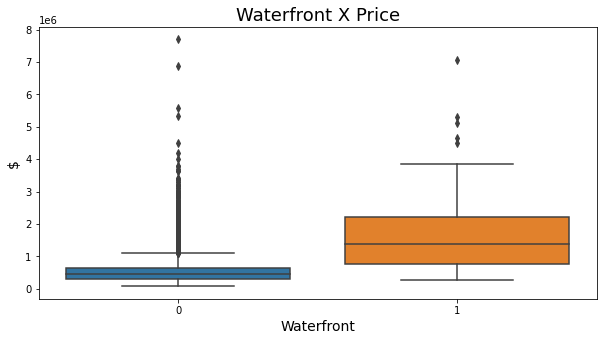

In [16]:
#Waterfront X Price
ax=sns.boxplot(x='Waterfront',y='Price',data=df1)
ax.set_title('Waterfront X Price',fontsize=18)
ax.figure.set_size_inches(10,5)
ax.set_ylabel('$',fontsize=14)
ax.set_xlabel('Waterfront',fontsize=14)
ax

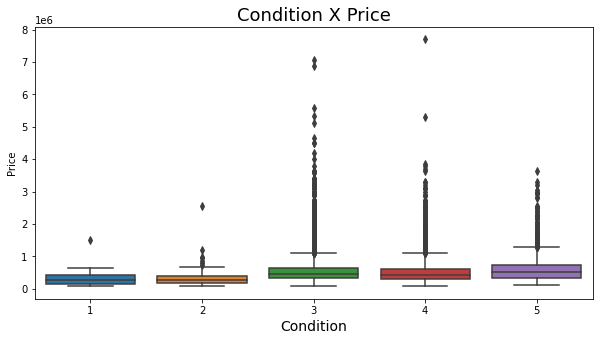

In [17]:
#Condition X Price
x_label=['1','2','3','4','5']
ax=sns.boxplot(x='Condition',y='Price',data=df1,order=x_label)
ax.set_title('Condition X Price',fontsize=18)
ax.figure.set_size_inches(10,5)
ax.set_xlabel('Condition',fontsize=14)
ax

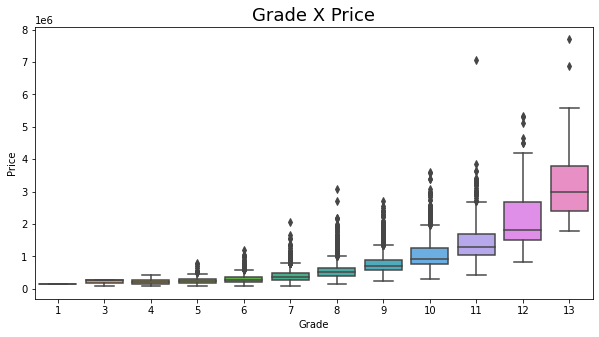

In [18]:
#Grade
x_label=['1','3','4','5','6','7','8','9','10','11','12','13']
ax=sns.boxplot(x='Grade',y='Price',data=df1,order=x_label)
ax.set_title('Grade X Price',fontsize=18)
ax.figure.set_size_inches(10,5)

#2.0. FEATURE ENGINEERING

In [19]:
df2=df1.copy()

## 2.1 Hypothesis mind map

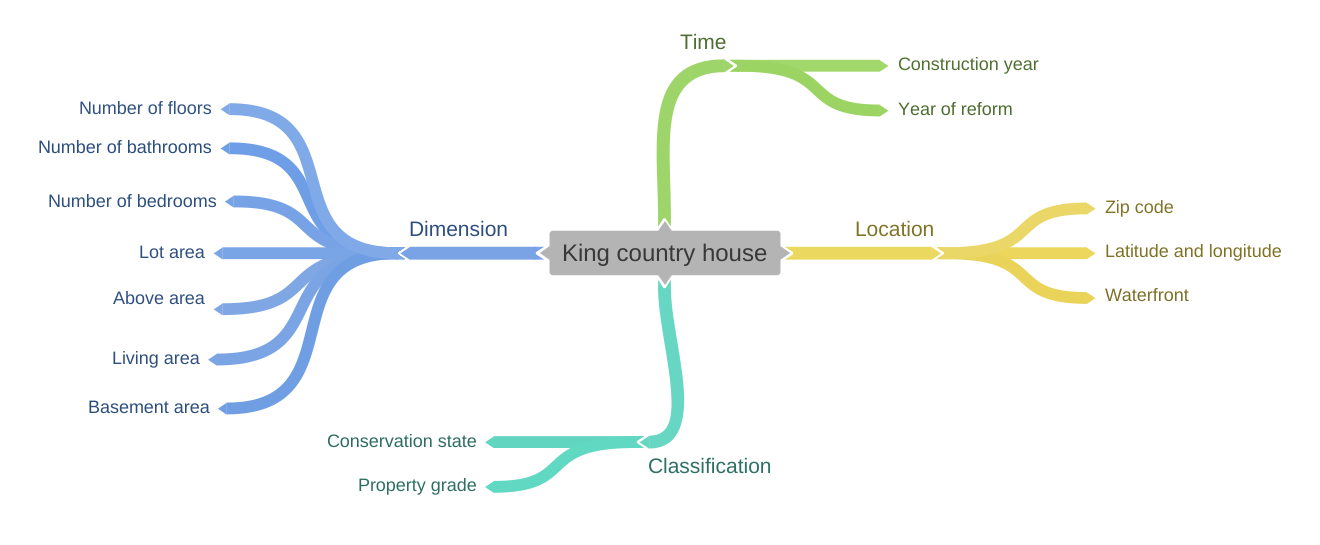

In [20]:
Image('/content/king_country_house_mind_map.png')

##2.2 Creation of hypotheses

### 2.2.1 Demension

**1.** Houses with the largest area on the lot
, has greater value.


**2.** Houses with a larger living room have greater value.


**3.** Houses with greater area above, have greater value.

**4.** Houses with greater underground area have greater value.|




**5.** Houses with more rooms, have higher value.

**6.** Houses with more floors have greater value.

**7.** Houses with greater number of bathrooms have greater value.

###2.2.2 Time

**1.** Houses with longer construction time have greater value.

**2.** Recently renovated houses have greater value.

###2.2.3 Classification

**1.** Houses with a higher level, have a higher value.

**2.** Houses with better conservation status have greater value.

###2.2.4 Location

**1.** Water front of houses has greater value.

**2.** Houses in privileged places have greater value.

###2.2.5. Final list of hypotheses

**H1.** Houses with the largest area on the lot
, has greater value.

**H2.** Houses with a larger living room have greater value.

**H3.** Houses with greater area above, have greater value.

**H4.** Houses with greater underground area have greater value.

**H5.** Houses with more rooms, have higher value.

**H6.** Houses with more floors have greater value.

**H7.** Houses with greater number of bathrooms have greater value.

**H8.** Houses with longer construction time have greater value.

**H9.** Recently renovated houses have greater value.

**H10.** Water front of houses and privileged locations, have greater value.




##2.3 Feature Engineering

###2.3.1 Time variables

In [21]:
#year of assessment
df2['YearOfAssessment']=df2['Date'].dt.year

#evaluation month
df2['EvaluationMonth']=df2['Date'].dt.month

#day
df2['Day']=df2['Date'].dt.day

#week of year
df2['WeekOfYear']=df2['Date'].dt.weekofyear

#time of existence
df2['TimeOfExistence']=df2['YearOfAssessment']-df2['YrBuilt']

#retirement time
df2['RetirementTime']=df2['YearOfAssessment']-df2['YrRenovated']

###2.3.2 Classification variables

In [22]:
#grade 
df2['Grade']=df2['Grade'].apply(lambda x:
                                
                                '1' if x=='1'  else '1' if x=='2'  else '1' if x=='3' else '1' if x=='4' else
                                '2' if x=='5'  else '2' if x=='6'  else '2' if x=='7' else
                                '3' if x=='8'  else '3' if x=='9'  else '3' if x=='10'else
                                '4' if x=='11' else '4' if x=='12' else '4' if x=='13'else

                                'no_group')

#water front
df2['Waterfront']=df2['Waterfront'].apply(lambda x:'yes' if x=='1'  else 'no')

###2.3.3 Location variables

In [23]:
df2[['Waterfront','Zipcode','Lat','Long']].head(3)

Waterfront  Zipcode    Lat     Long
0         no    98178 47.511 -122.257
1         no    98125 47.721 -122.319
2         no    98028 47.738 -122.233

###2.3.4 Dimensional variables

In [24]:
#turning square feet into square meters
aux=['SqftLiving','SqftLot','SqftAbove','SqftBasement','SqftLiving15','SqftLot15']
df2[aux]=df2[aux]*0.0929

#living room increase
df2['LivingRoomIncrease']=df2['SqftLiving15']-df2['SqftLiving']

#increase in lot area
df2['IncreaseInLotArea']=df2['SqftLot15']-df2['SqftLot']

#3.0. VARIABLES FILTERING

In [25]:
df3=df2.copy()

##3.1. Line Filtering

In [26]:
variables_for_verification=[  'Price','Bedrooms','Bathrooms','SqftLiving',
                              'SqftLot','Floors','SqftAbove','SqftBasement',
                              'SqftLiving15','SqftLot15','LivingRoomIncrease',
                              'IncreaseInLotArea']

aux=delete_outliers(df3,variables_for_verification)
df3=aux[0].copy()
print('Number of deleted lines: {}'.format(aux[1]))

Number of deleted lines: 2450


##3.2. Column selection

In [27]:
#removing columns
cols_drop=['YrRenovated','View']
df3=df3.drop(cols_drop,axis=1)

#4.0. EXPLORATORY DATA ANALYSIS

In [28]:
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

The price range of properties is between $ 310975.0 and $ 599000.0


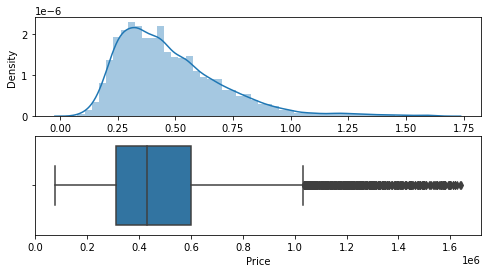

In [29]:
plt.subplot(2,1,1)
ax=sns.distplot(df4['Price'])
ax.figure.set_size_inches(8,4)

plt.subplot(2,1,2)
ax=sns.boxplot(df4['Price'])

q1=df4['Price'].quantile(0.25)
q3=df4['Price'].quantile(0.75)
print('The price range of properties is between $ {} and $ {}'.format(q1,q3))

###4.1.2. Numerical Variable

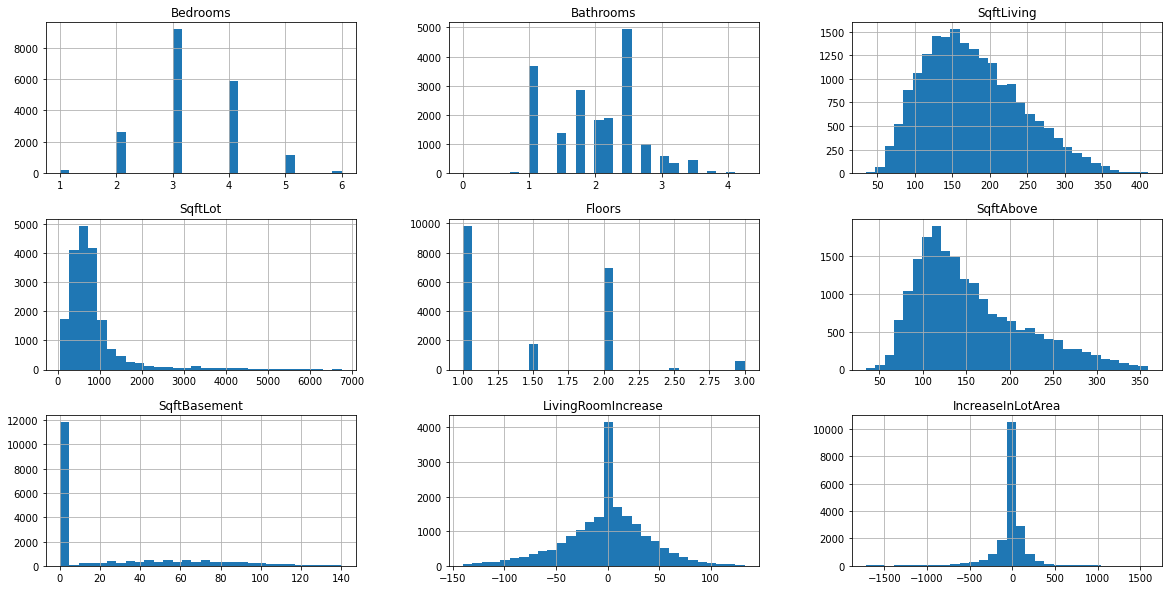

In [30]:
aux=df4[['Bedrooms','Bathrooms','SqftLiving','SqftLot',
         'Floors','SqftAbove','SqftBasement','LivingRoomIncrease',
         'IncreaseInLotArea']]
         
aux.hist(bins=30,figsize=(20,10));

###4.1.3. Categorical Variable

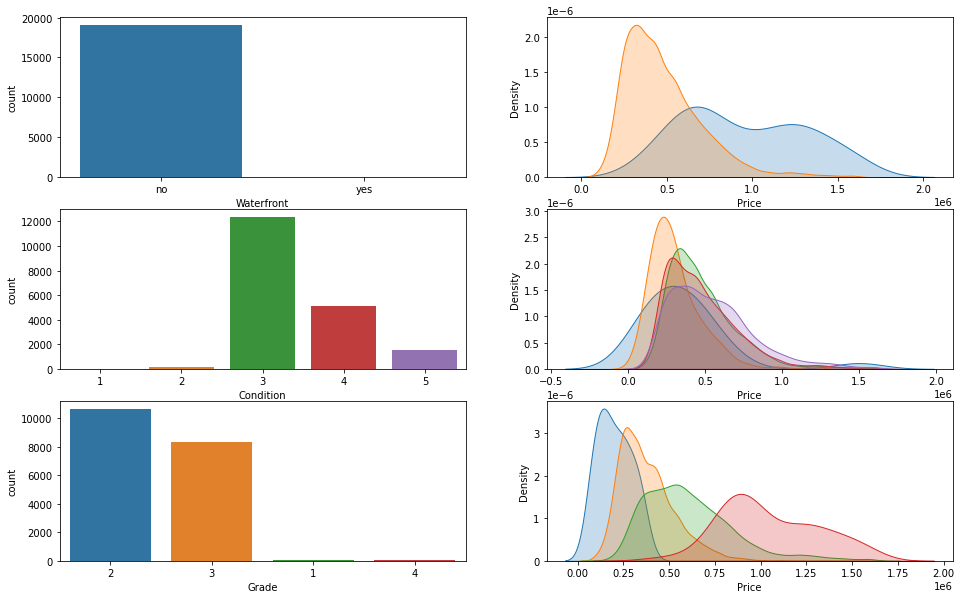

In [31]:
#waterfront
plt.subplot(3,2,1)
ax=sns.countplot(df4['Waterfront'])
ax.figure.set_size_inches(16,10)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['Waterfront']=='yes']['Price'],label='yes',shade=True)
sns.kdeplot(df4[df4['Waterfront']=='no']['Price'],label='no',shade=True)

#condition
plt.subplot(3,2,3)
ordem_colunas=['1','2','3','4','5']
ax=sns.countplot(df4['Condition'],order=ordem_colunas)

plt.subplot(3,2,4)
for i in range(1,6):
  i=str(i)
  sns.kdeplot(df4[df4['Condition']==i]['Price'],label=i,shade=True)

#grade
plt.subplot(3,2,5)
ax=sns.countplot(df4['Grade'])

plt.subplot(3,2,6)
for i in range(0,5):
  i=str(i)
  sns.kdeplot(df4[df4['Grade']==i]['Price'],label=i,shade=True)

## 4.2 Bivariate Analysis

Correlation:


*   0,10 - 0,29 (low)
*   0,30 - 0,49 (medium)
*   0,50 - 1    (high)

###***H1***. Houses with the largest area on the lot , has greater value. (FALSE)

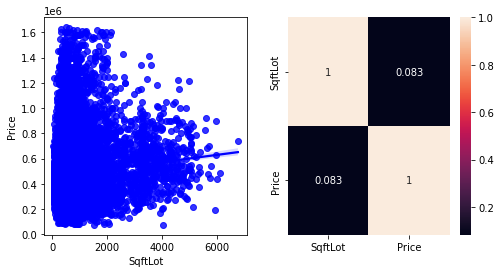

In [32]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftLot',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftLot','Price']].corr(method='pearson'),annot=True);

###***H2***. Houses with a larger living room have greater value.(TRUE)

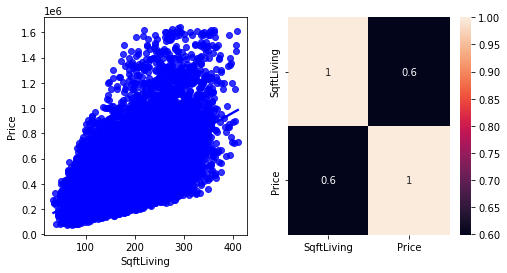

In [33]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftLiving',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftLiving','Price']].corr(method='pearson'),annot=True);

###***H3***. Houses with greater area above, have greater value. (TRUE)

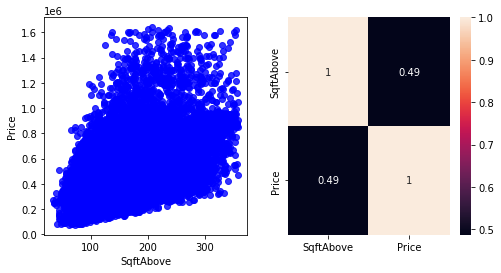

In [34]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftAbove',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftAbove','Price']].corr(method='pearson'),annot=True);

###***H4***. Houses with greater underground area have greater value. (FALSE)

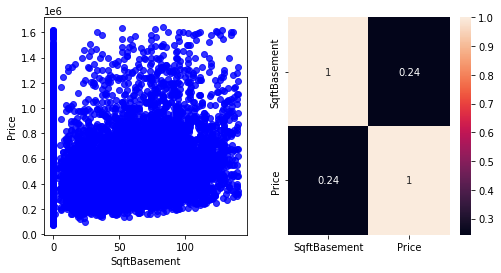

In [35]:
plt.subplot(1,2,1)
ax=sns.regplot(x='SqftBasement',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['SqftBasement','Price']].corr(method='pearson'),annot=True);

###***H5***. Houses with more rooms, have higher value. (FALSE)

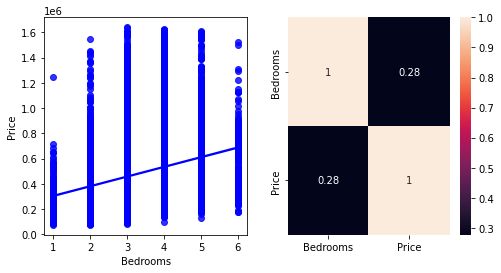

In [36]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Bedrooms',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Bedrooms','Price']].corr(method='pearson'),annot=True);

###***H6***. Houses with more floors have greater value. (FALSE)

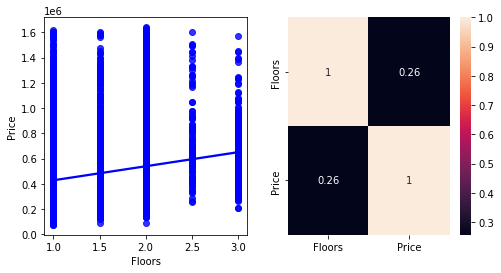

In [37]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Floors',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Floors','Price']].corr(method='pearson'),annot=True);

###***H7***. Houses with greater number of bathrooms have greater value. (TRUE)

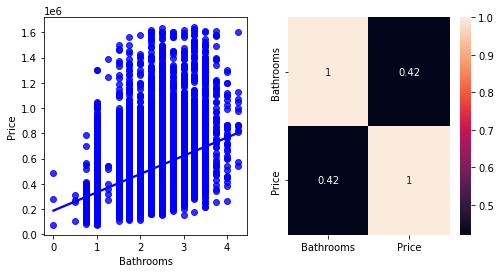

In [38]:
plt.subplot(1,2,1)
ax=sns.regplot(x='Bathrooms',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(8,4)   

plt.subplot(1,2,2)
ax=sns.heatmap(df4[['Bathrooms','Price']].corr(method='pearson'),annot=True);

###***H8***. Houses with longer construction time have greater value. (FALSE)

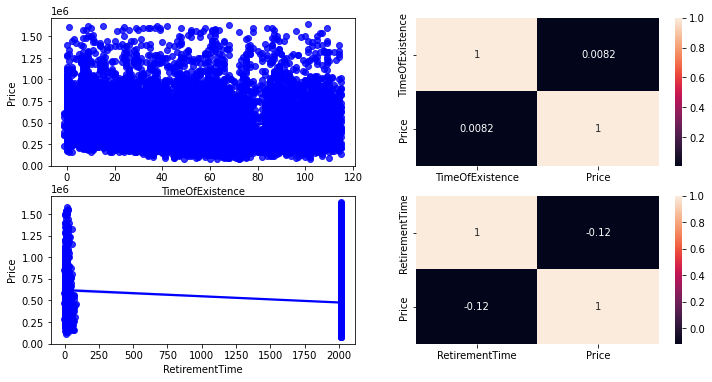

In [39]:
plt.subplot(2,2,1)#FALSE
ax=sns.regplot(x='TimeOfExistence',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(12,6)   

plt.subplot(2,2,2)
ax=sns.heatmap(df4[['TimeOfExistence','Price']].corr(method='pearson'),annot=True);

plt.subplot(2,2,3)#FALSE
ax=sns.regplot(x='RetirementTime',y='Price',data=df4,color='blue')
ax.figure.set_size_inches(12,6)   

plt.subplot(2,2,4)
ax=sns.heatmap(df4[['RetirementTime','Price']].corr(method='pearson'),annot=True);

###***H9***. Recently renovated houses have greater value. (TRUE)

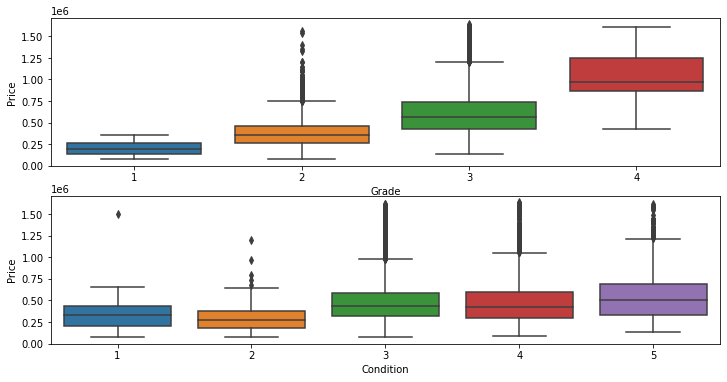

In [40]:
#grade (TRUE)
plt.subplot(2,1,1)
x_label=['1','2','3','4']
ax=sns.boxplot(x='Grade',y='Price',data=df4,order=x_label)
ax.figure.set_size_inches(12,6)

#condition (FALSE)
plt.subplot(2,1,2)
x_label=['1','2','3','4','5']
ax=sns.boxplot(x='Condition',y='Price',data=df4,order=x_label)
ax

###***H10***. Water front of houses and privileged locations, have greater value. (TRUE)

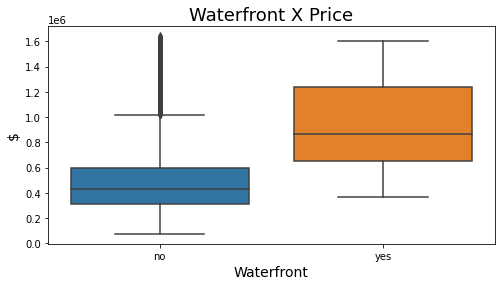

In [41]:
#waterfront X prices(TRUE)
ax=sns.boxplot(x='Waterfront',y='Price',data=df4)
ax.set_title('Waterfront X Price',fontsize=18)
ax.figure.set_size_inches(8,4)
ax.set_ylabel('$',fontsize=14)
ax.set_xlabel('Waterfront',fontsize=14)
ax

### 4.2.1 Summary of hypotheses

In [42]:
tab=[['hypotheses','Conclusion','Relevance'],
     ['H1',        'False',     'Low'],
     ['H2',        'True',      'High'],
     ['H3',        'True',      'High'],
     ['H4',        'False',     'Low'],
     ['H5',        'False',     'Low'],
     ['H6',        'False',     'Low'],
     ['H7',        'True',      'Medium'],
     ['H8',        'False',     'Low'],
     ['H9',        'True',      'Medium'],
     ['H10',       'True',      'Medium']]

print(tabulate(tab,headers='firstrow'))

hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            True          High
H3            True          High
H4            False         Low
H5            False         Low
H6            False         Low
H7            True          Medium
H8            False         Low
H9            True          Medium
H10           True          Medium


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

Text(0.5, 1.0, 'Correlation between numerical features')

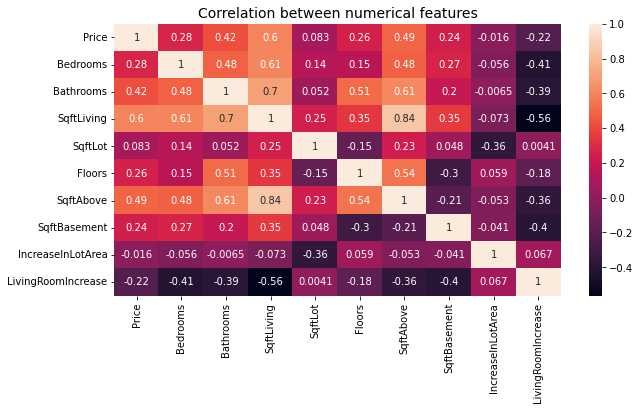

In [43]:
aux=df4[[ 'Price','Bedrooms','Bathrooms','SqftLiving','SqftLot',
          'Floors','SqftAbove','SqftBasement','IncreaseInLotArea','LivingRoomIncrease']]

correlation=aux.corr(method='pearson')
ax=sns.heatmap(correlation,annot=True);
ax.figure.set_size_inches(10,5)
ax.set_title('Correlation between numerical features',fontsize=14)

###4.3.2. Categorical Atributes

In [44]:
a=df4.select_dtypes(include='object')

#waterfront
a1=cramer_v(a['Waterfront'],a['Waterfront'])
a2=cramer_v(a['Waterfront'],a['Condition'])
a3=cramer_v(a['Waterfront'],a['Grade'])

#condition
a4=cramer_v(a['Condition'],a['Waterfront'])
a5=cramer_v(a['Condition'],a['Condition'])
a6=cramer_v(a['Condition'],a['Grade'])

#grade
a7=cramer_v(a['Grade'],a['Waterfront'])
a8=cramer_v(a['Grade'],a['Condition'])
a9=cramer_v(a['Grade'],a['Grade'])


d=pd.DataFrame({ 'Waterfront':  [a1,a2,a3,],
                 'Condition':   [a4,a5,a6],
                 'Grade':       [a7,a8,a9]                 
                })

d=d.set_index(d.columns)

d.head()

Waterfront  Condition  Grade
Waterfront       0.993      0.028  0.025
Condition        0.028      1.000  0.116
Grade            0.025      0.116  1.000

## 4.4 Report

### 1 - What is the oldest record?

In [45]:
df4.sort_values('Date',ascending=True).head(1)

Id       Date  ...  LivingRoomIncrease  IncreaseInLotArea
7961  5101405331 2014-05-02  ...             -47.379              0.000

[1 rows x 27 columns]

### 2 - How many properties have the maximum number of floors?

In [46]:
max=df4['Floors'].max()
df4[df4['Floors']==max].shape[0]

567

### 3 - Create a classification for properties, separating them into low and high standard, according to price.
*  Above 540.00 is high standard.
*  Below 540.00 is low standard.

In [47]:
df4['Classification']=df4['Price']
df4['Classification']=df4['Classification'].apply(lambda x : 'High' if x>=540000 else  'Low' if x<540000 else x)
df4.head(3)

Id       Date  ...  IncreaseInLotArea  Classification
0  7129300520 2014-10-13  ...              0.000             Low
1  6414100192 2014-12-09  ...             36.881             Low
3  2487200875 2014-12-09  ...              0.000            High

[3 rows x 28 columns]

### 4 - I would like a report ordered by price and with the following information:

*   Property ID
*   Date the property became available for purchase
*   Number of bedrooms 
*   Total lot size
*   Price  
*   Rating (High and Low default)


In [48]:
df4[['Id','Date','Bedrooms','SqftLot','Price','Classification']].sort_values('Price',ascending=False)

Id       Date  Bedrooms  SqftLot       Price Classification
13633  3528900401 2014-07-01         3  505.840 1640000.000           High
15924  7533800170 2014-07-07         3  628.468 1636000.000           High
14233  5318101565 2014-07-03         4  334.440 1625000.000           High
2564   7856400240 2014-06-27         4  905.775 1620000.000           High
11843  2450500060 2014-08-26         4  753.791 1620000.000           High
...           ...        ...       ...      ...         ...            ...
8274   3883800011 2014-11-05         3  968.575   82000.000            Low
16198  3028200080 2015-03-24         2  926.678   81000.000            Low
465    8658300340 2014-05-23         1  469.145   80000.000            Low
15293    40000362 2014-05-06         2 1518.358   78000.000            Low
1149   3421079032 2015-02-17         1 4029.723   75000.000            Low

[19163 rows x 6 columns]

### 5 - What is the amount of real estate per year of construction?

In [49]:
aux=df4[['Id','YrBuilt']].groupby('YrBuilt').count().reset_index()
columns={'YrBuilt':'YrBuilt','Id':'TheAmount'}
aux=aux.rename(columns=columns)
aux

YrBuilt  TheAmount
0       1900         79
1       1901         26
2       1902         24
3       1903         44
4       1904         43
..       ...        ...
111     2011        120
112     2012        156
113     2013        172
114     2014        474
115     2015         27

[116 rows x 2 columns]

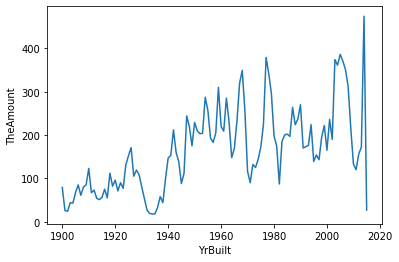

In [50]:
ax=sns.lineplot(x='YrBuilt',y='TheAmount',data=aux)

### 6 - What is the smallest number of rooms per year of real estate construction?

In [51]:
aux=df4[['Bedrooms','YrBuilt']].groupby('YrBuilt').min().reset_index()
aux

YrBuilt  Bedrooms
0       1900         1
1       1901         2
2       1902         2
3       1903         1
4       1904         2
..       ...       ...
111     2011         1
112     2012         2
113     2013         2
114     2014         1
115     2015         1

[116 rows x 2 columns]

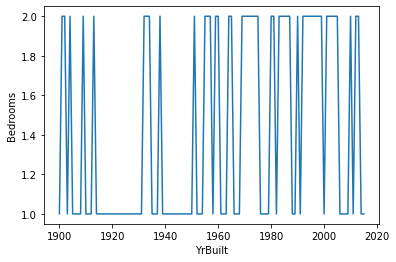

In [52]:
ax=sns.lineplot(x='YrBuilt',y='Bedrooms',data=aux)

### 7 - What is the highest purchase price for each number of rooms?

In [53]:
aux=df4[['Price','Bedrooms']].groupby('Bedrooms').max().reset_index()
aux

Bedrooms       Price
0         1 1247000.000
1         2 1550000.000
2         3 1640000.000
3         4 1625000.000
4         5 1610000.000
5         6 1520000.000

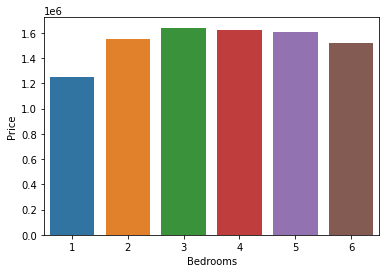

In [54]:
ax=sns.barplot(x='Bedrooms',y='Price',data=aux)

### 8 - What is the sum of all purchase prices per number of rooms?

In [55]:
aux=df4[['Price','Bedrooms']].groupby('Bedrooms').sum().reset_index()
aux

Bedrooms          Price
0         1   56572634.000
1         2 1031049918.000
2         3 4068032032.000
3         4 3267212365.000
4         5  695674964.000
5         6   98968954.000

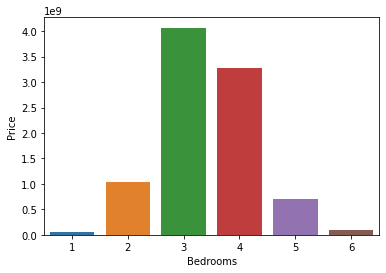

In [56]:
ax=sns.barplot(x='Bedrooms',y='Price',data=aux)

### 9 - What is the average room size in the buildings per year of construction?

In [57]:
aux=df4[['SqftLiving','YrBuilt']].groupby('YrBuilt').mean().reset_index()
aux

YrBuilt  SqftLiving
0       1900     152.385
1       1901     153.696
2       1902     156.459
3       1903     137.560
4       1904     137.002
..       ...         ...
111     2011     201.828
112     2012     212.624
113     2013     222.026
114     2014     222.817
115     2015     188.415

[116 rows x 2 columns]

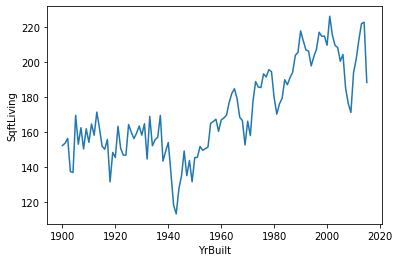

In [58]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 10 - What is the median size of property rooms per year of construction?

In [59]:
aux=df4[['YrBuilt','SqftLiving']].groupby('YrBuilt').median().reset_index()
aux

YrBuilt  SqftLiving
0       1900     139.350
1       1901     141.208
2       1902     143.066
3       1903     131.918
4       1904     118.912
..       ...         ...
111     2011     202.522
112     2012     201.593
113     2013     228.534
114     2014     226.676
115     2015     163.504

[116 rows x 2 columns]

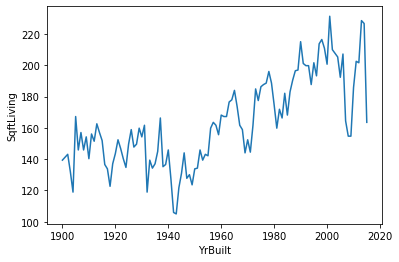

In [60]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 11 - What is the standard deviation of room size in buildings per year of construction?

In [61]:
aux=df4[['YrBuilt','SqftLiving']].groupby('YrBuilt').std().reset_index()
aux

YrBuilt  SqftLiving
0       1900      59.454
1       1901      56.846
2       1902      48.148
3       1903      42.942
4       1904      51.048
..       ...         ...
111     2011      58.511
112     2012      63.413
113     2013      57.983
114     2014      67.957
115     2015      68.453

[116 rows x 2 columns]

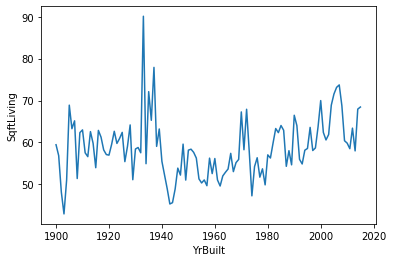

In [62]:
ax=sns.lineplot(x='YrBuilt',y='SqftLiving',data=aux)

### 12 - What is the average growth in property purchase prices, by year, month, day and week of the year?

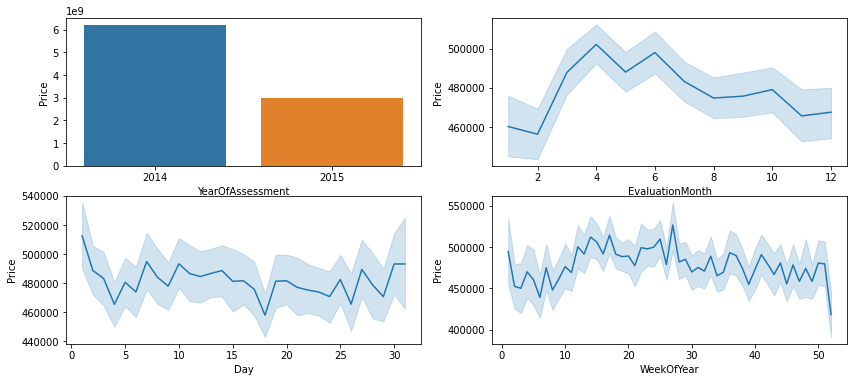

In [63]:
plt.subplot(2,2,1)
aux=df4[['YearOfAssessment','Price']].groupby('YearOfAssessment').sum().reset_index()
ax=sns.barplot(x='YearOfAssessment',y='Price',data=aux)
ax.figure.set_size_inches(14,6)

plt.subplot(2,2,2)
ax=sns.lineplot(x='EvaluationMonth',y='Price',data=df4)

plt.subplot(2,2,3)
ax=sns.lineplot(x='Day',y='Price',data=df4)

plt.subplot(2,2,4)
ax=sns.lineplot(x='WeekOfYear',y='Price',data=df4)

### 13 - I would like to look at the map and be able to identify homes with the highest price.

In [64]:
DataMap=df4[['Id','Lat','Long','Price']]

#maps
map=px.scatter_mapbox(    DataMap, 
                          lat='Lat',
                          lon='Long',
                          size='Price',
                          color_continuous_scale=px.colors.cyclical.IceFire,
                          size_max=15,
                          zoom=10)

map.update_layout(mapbox_style='open-street-map')
map.update_layout(height = 600 ,margin={'r':0,'t':0,'l':0,'b':0})

#save map
map.write_html('/content/map.html')

#read map
display(HTML('/content/map.html'))

# 5.0. DATA PREPARATION

In [65]:
df5=df4.copy()

#separating the test dataset from the deploy
dataset_deploy=df_raw[df_raw.index>df_raw.shape[0]-3000]
dataset_deploy=dataset_deploy.drop(['price'],axis=1)

d5=df5[df5.index<=df5.shape[0]-3000]
df5=df5.drop(['Classification'],axis=1)

## 5.1. Rescaling

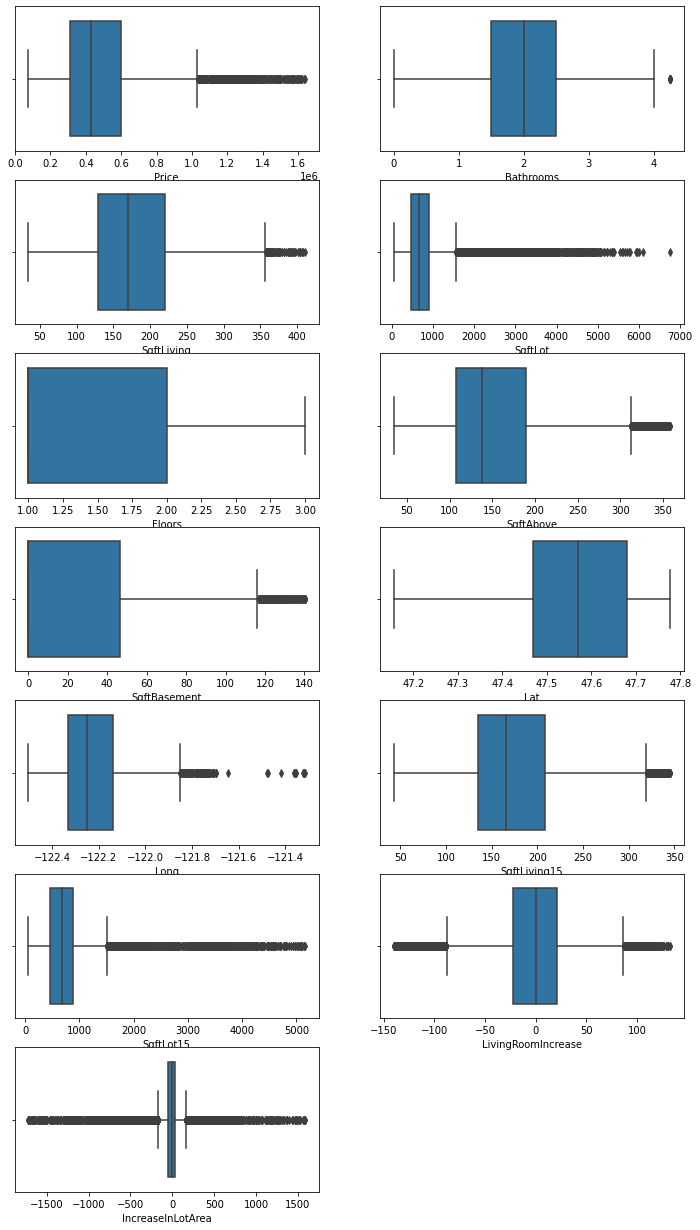

In [66]:
#numerical and categorical attributes
num_attributes=df5.select_dtypes(include=['int64','float64'])
cat_attributes=df5.select_dtypes(include=['object','int32'])

#outliers view
columns=num_attributes.columns

for i in range(0,len(columns)):

  plt.subplot(8,2,i+1)
  ax=sns.boxplot(num_attributes[columns[i]])
  ax.figure.set_size_inches(12,25)

In [67]:
mms=MinMaxScaler()
rs=RobustScaler()

#MinMaxScaler
#Floors
df5['Floors']=mms.fit_transform(df5[['Floors']].values)

#TimeOfExistence
df5['TimeOfExistence']=mms.fit_transform(df5[['TimeOfExistence']].values)
pickle.dump(mms,open('/content/TimeOfExistence_scaler.pkl','wb'))

#YrBuilt
df5['YrBuilt']=mms.fit_transform(df5[['YrBuilt']].values)
pickle.dump(mms,open('/content/YrBuilt_scaler.pkl','wb'))

#Lat
df5['Lat']=mms.fit_transform(df5[['Lat']].values)
pickle.dump(mms,open('/content/Lat_scaler.pkl','wb'))

#SqftLot15
df5['SqftLot15']=mms.fit_transform(df5[['SqftLot15']].values)
pickle.dump(mms,open('/content/SqftLot15_scaler.pkl','wb'))

#RobustScaler
#SqftLot
df5['SqftLot']=rs.fit_transform(df5[['SqftLot']].values)
pickle.dump(mms,open('/content/SqftLot_scaler.pkl','wb'))

#SqftLiving15
df5['SqftLiving15']=rs.fit_transform(df5[['SqftLiving15']].values)
pickle.dump(mms,open('/content/SqftLiving15_scaler.pkl','wb'))

#RetirementTime
df5['RetirementTime']=rs.fit_transform(df5[['RetirementTime']].values)

#Bathrooms
df5['Bathrooms']=rs.fit_transform(df5[['Bathrooms']].values)
pickle.dump(rs,open('/content/Bathrooms_scaler.pkl','wb'))

#Bedrooms
df5['Bedrooms']=rs.fit_transform(df5[['Bedrooms']].values)

#SqftLiving
df5['SqftLiving']=rs.fit_transform(df5[['SqftLiving']].values)
pickle.dump(rs,open('/content/SqftLiving_scaler.pkl','wb'))

#SqftAbove
df5['SqftAbove']=rs.fit_transform(df5[['SqftAbove']].values)
pickle.dump(rs,open('/content/SqftAbove_scaler.pkl','wb'))

#SqftBasement
df5['SqftBasement']=rs.fit_transform(df5[['SqftBasement']].values)

#LivingRoomIncrease
df5['LivingRoomIncrease']=rs.fit_transform(df5[['LivingRoomIncrease']].values)
pickle.dump(rs,open('/content/LivingRoomIncrease_scaler.pkl','wb'))

#IncreaseInLotArea
df5['IncreaseInLotArea']=rs.fit_transform(df5[['IncreaseInLotArea']].values)
pickle.dump(rs,open('/content/IncreaseInLotArea_scaler.pkl','wb'))

#Long
df5['Long']=rs.fit_transform(df5[['Long']].values)
pickle.dump(rs,open('/content/Long_scaler.pkl','wb'))

## 5.2. Transformation

### 5.2.1. Encoding

In [68]:
#One Hot Encoding
#Waterfront 
df5=pd.get_dummies(df5,prefix=['Waterfront'],columns=['Waterfront'])

#Label Encoding
le=LabelEncoder()
#Zipcode
df5['Zipcode']=le.fit_transform(df5['Zipcode'])
pickle.dump(le,open('/content/Zipcode_scaler.pkl','wb'))

#Ordinal Encoding
#Condition
r=0.2
assortment_dict={'1':1*r,'2':2*r,'3':3*r,'4':4*r,'5':5*r}
df5['Condition']=df5['Condition'].map(assortment_dict)

#Grade
a=0.06
assortment_dict={'1':1*a,'2':2*a,'3':3*a,'4':4*a,'5':5*a,'6':6*a,'7':7*a,'8':8*a,'9':9*a,'10':10*a,'11':11*a,'12':12*a,'13':13*a}
df5['Grade']=df5['Grade'].map(assortment_dict)

### 5.2.2. Response Variable transformation

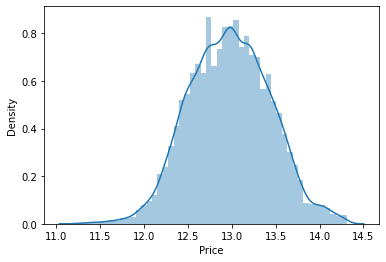

In [69]:
df5['Price']=np.log1p(df5['Price'])
sns.distplot(df5['Price'])

### 5.2.3. Nature transformation

In [70]:
#Month
df5['EvaluationMonthSin']=      df5['EvaluationMonth'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
df5['EvaluationMonthSinCos']=   df5['EvaluationMonth'].apply(lambda x:np.cos(x*(2.*np.pi/12)))
df5=df5.drop(['EvaluationMonth'],axis=1)

#YearOfAssessment
df5['YearOfAssessment']=np.log1p(df5['YearOfAssessment'])

#Day
df5['DaySin']=df5['Day'].apply(lambda x:np.sin(x*(2.*np.pi/30)))
df5['DayCos']=df5['Day'].apply(lambda x:np.cos(x*(2.*np.pi/30)))
df5=df5.drop(['Day'],axis=1)

#WeekOfYear
df5['WeekOfYearSin']=df5['WeekOfYear'].apply(lambda x:np.sin(x*(2.*np.pi/52)))
df5['WeekOfYearCos']=df5['WeekOfYear'].apply(lambda x:np.cos(x*(2.*np.pi/52)))
df5=df5.drop(['WeekOfYear','Date'],axis=1)

#6.0. FEATURE SELECTION

In [71]:
df6=df5.copy()

##6.1. Split dataframe into training and test dataset.

In [72]:
#Split train and test
y=df6['Price']
x=df6.drop(['Price','Id'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2811)

##6.2. Boruta as feature selector


In [73]:
boruta=boruta(x_train,y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	14
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Reject

###6.2.1. Best Features from Boruta

In [74]:
best_features(boruta,x_train)

['SqftLiving',
 'SqftLot',
 'Grade',
 'SqftAbove',
 'YrBuilt',
 'Zipcode',
 'Lat',
 'Long',
 'SqftLiving15',
 'SqftLot15',
 'TimeOfExistence',
 'LivingRoomIncrease',
 'IncreaseInLotArea']

##6.3. Manual Feature selection


In [75]:
cols_selected_boruta=['SqftLiving','SqftLot', 'Grade','SqftAbove',
                      'YrBuilt','Zipcode','Lat','Long','SqftLiving15',
                      'SqftLot15','TimeOfExistence','LivingRoomIncrease',
                      'IncreaseInLotArea']

#Columns to add
feat_to_add=['Price']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add) 

# 7.0. MACHINE LEARNING MODELLING

In [76]:
x_train=x_train[cols_selected_boruta]
x_test=x_test[cols_selected_boruta]

df7=df6[cols_selected_boruta_full].copy()

## 7.1. Base Line

In [77]:
#Model
lr=LinearRegression()
lr_train=lr.fit(x_train,y_train)

#Prediction
yhat_lr=lr_train.predict(x_test)

#Performance
baseline_results=ml_error('BaseLine',np.expm1(y_test),np.expm1(yhat_lr))
baseline_results

ModelName        MAE  MAPE       RMSE
0  BaseLine 101256.840 0.216 146270.061

### 7.1.1. Linear Regression Model- Cross Validation

In [78]:
baseline_results_cv=cross_validation(df7,5,'BaseLine',lr,'Price')
baseline_results_cv

Model name                  MAE CV        MAPE CV                  RMSE CV
0   BaseLine  96170.98 +/- 22667.327  0.2 +/- 0.043  125473.82 +/- 29091.493

## 7.2. Linear Regression Regularized Model-Lasso

In [79]:
#Model
lrr=Lasso(alpha=0.01)
lrr_train=lrr.fit(x_train,y_train)

#Prediction
yhat_lrr=lrr_train.predict(x_test)

#Performance
lrr_results=ml_error('Linear Regressor-Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_results

ModelName        MAE  MAPE       RMSE
0  Linear Regressor-Lasso 109585.977 0.232 158528.696

### 7.2.1. Linear Regression Regularized Model-Lasso-  Cross Validation

In [80]:
lrr_results_cv=cross_validation(df7,5,'Lasso',lrr,'Price')
lrr_results_cv

Model name                   MAE CV         MAPE CV                  RMSE CV
0      Lasso  113429.35 +/- 21696.279  0.23 +/- 0.041  150799.93 +/- 20784.056

## 7.3. Random Forest Regressor

In [81]:
#Model
rf=RandomForestRegressor(n_estimators=10,n_jobs=-1,random_state=42)
rf_train=rf.fit(x_train,y_train)

#Prediction
yhat_rf=rf_train.predict(x_test)

#Performance
rf_results=ml_error('Random Forest',np.expm1(y_test),np.expm1(yhat_rf))
rf_results

ModelName       MAE  MAPE      RMSE
0  Random Forest 63024.282 0.137 99267.806

### 7.3.1. Random Forest Regressor-Cross validation

In [82]:
rf_results_cv=cross_validation(df7,5,'Rendom Forest Regressor',rf,'Price')
rf_results_cv

Model name  ...               RMSE CV
0  Rendom Forest Regressor  ...  87135.3 +/- 10577.35

[1 rows x 4 columns]

## 7.4. XGBoost Regressor

In [83]:
#Model
xgb_model=xgb.XGBRegressor(objective='reg:squarederror',
                           eta=0.01,max_depth=10,
                           subsample=0.7,
                           colsample_bytree=0.9)

xgb_train=xgb_model.fit(x_train,y_train)

#Prediction
yhat_xgb=xgb_train.predict(x_test)

#Performance
xgb_results=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_results

ModelName       MAE  MAPE      RMSE
0  XGBoost Regressor 57086.637 0.124 91897.644

### 7.4.1. XGBoost Regressor-Cross validation

In [84]:
xgb_results_cv=cross_validation(df7,5,'XGBoost Regressor',xgb_model,'Price')
xgb_results_cv

Model name  ...                 RMSE CV
0  XGBoost Regressor  ...  72831.03 +/- 16743.569

[1 rows x 4 columns]

## 7.5. Ridge

In [85]:
#Model
r = Ridge(alpha=1.0)
r_train=r.fit(x_train,y_train)

#Predict
yhat_r=r_train.predict(x_test)

#Performance
r_results=ml_error('Ridge',np.expm1(y_test),np.expm1(yhat_r))
r_results

ModelName        MAE  MAPE       RMSE
0     Ridge 101620.537 0.217 146683.582

###7.5.1. Ridge-Cross validation

In [86]:
r_results_cv=cross_validation(df7,5,'Ridge',r,'Price')
r_results_cv

Model name                  MAE CV        MAPE CV                 RMSE CV
0      Ridge  95506.13 +/- 22296.993  0.2 +/- 0.041  124813.1 +/- 28837.017

## 7.6. ExtraTreesRegressor

In [87]:
#Model
etr=ExtraTreesRegressor(n_estimators=100, random_state=0)
etr_training=etr.fit(x_train,y_train)

#Predictions
yhat_etr=etr_training.predict(x_test)

#Performance
etr_results=ml_error('ExtraTreesRegressor',np.expm1(y_test),np.expm1(yhat_etr))
etr_results

ModelName       MAE  MAPE      RMSE
0  ExtraTreesRegressor 59777.864 0.130 96793.313

###7.6.1. ExtraTreesRegressorr -Cross validation

In [88]:
etr_results_cv=cross_validation(df7,5,'ExtraTreesRegressor',etr,'Price')
etr_results_cv

Model name  ...                 RMSE CV
0  ExtraTreesRegressor  ...  72334.65 +/- 12917.785

[1 rows x 4 columns]

## 7.7. Compare Model's Performance

### 7.7.1. Single Performance

In [89]:
modelling_results=pd.concat([baseline_results,lrr_results,rf_results,xgb_results,r_results,etr_results])
modelling_results=modelling_results.sort_values('MAPE',ascending=True)
modelling_results

ModelName        MAE  MAPE       RMSE
0       XGBoost Regressor  57086.637 0.124  91897.644
0     ExtraTreesRegressor  59777.864 0.130  96793.313
0           Random Forest  63024.282 0.137  99267.806
0                BaseLine 101256.840 0.216 146270.061
0                   Ridge 101620.537 0.217 146683.582
0  Linear Regressor-Lasso 109585.977 0.232 158528.696

### 7.7.2. Real Performance - Cross Validation

In [90]:
modelling_results_cv=pd.concat([baseline_results_cv,lrr_results_cv,rf_results_cv,xgb_results_cv,r_results_cv,etr_results_cv])
modelling_results_cv=modelling_results_cv.sort_values('MAPE CV')
modelling_results_cv

Model name  ...                  RMSE CV
0        XGBoost Regressor  ...   72831.03 +/- 16743.569
0      ExtraTreesRegressor  ...   72334.65 +/- 12917.785
0  Rendom Forest Regressor  ...     87135.3 +/- 10577.35
0                    Ridge  ...   124813.1 +/- 28837.017
0                 BaseLine  ...  125473.82 +/- 29091.493
0                    Lasso  ...  150799.93 +/- 20784.056

[6 rows x 4 columns]

# 8.0. HYPERPARAMETER FINE TUNING

In [91]:
df8=df7.copy()

## 8.1.Random Search

In [92]:
df8=df7.copy()

In [93]:
#Params
param={  'n_estimators':        [1500,1700,2500,3000,3500],
         'eta':                 [0.01,0.03],
         'max_depth':           [3,5,9],
         'subsample':           [0.1,0.5,0.7],
         'colsample_bytree':    [0.3,0.7,0.9],
         'min_child_weight':    [3,8,15]
}


MAX_EVAL=10


final_results=pd.DataFrame()

for i in range (MAX_EVAL):

  #Choose values for parameters randomly
  hp={k:random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  #Model
  model_xgb=xgb.XGBRegressor(   objective='reg:squarederror',
                                n_estimators=       hp['n_estimators'],
                                eta=                hp['eta'],
                                max_depth=          hp['max_depth'],
                                subsample=          hp['subsample'],
                                colsample_bytree=   hp['colsample_bytree'],
                                min_child_weight=   hp['min_child_weight'])
  
  #Performance
  results=cross_validation(df8,5,'XGBRegressor',model_xgb,'Price') 
  final_results=pd.concat([final_results,results])
final_results

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 

Model name  ...                  RMSE CV
0  XGBRegressor  ...    76545.5 +/- 15099.995
0  XGBRegressor  ...    72075.65 +/- 9159.693
0  XGBRegressor  ...   72038.96 +/- 14008.692
0  XGBRegressor  ...  107651.92 +/- 32862.445
0  XGBRegressor  ...   75592.28 +/- 23930.332
0  XGBRegressor  ...   79174.09 +/- 22842.735
0  XGBRegressor  ...   72066.25 +/- 11918.083
0  XGBRegressor  ...    82352.61 +/- 22723.24
0  XGBRegressor  ...     74906.6 +/- 6293.246
0  XGBRegressor  ...   79158.26 +/- 20932.766

[10 rows x 4 columns]

## 8.2.Final Model

In [94]:
#param_tuned
param_tuned={'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}


#model
model_xgb_tuned=xgb.XGBRegressor(   objective=         'reg:squarederror',
                                    n_estimators=       param_tuned['n_estimators'],
                                    eta=                param_tuned['eta'],
                                    max_depth=          param_tuned['max_depth'],
                                    subsample=          param_tuned['subsample'],
                                    colsample_bytree=   param_tuned['colsample_bytree'],
                                    min_child_weight=   param_tuned['min_child_weight'])
#training
model_xgb_tuned_train=model_xgb_tuned.fit(x_train,y_train)

#prediction
yhat_xgb_tuned=model_xgb_tuned_train.predict(x_test) 

#performance
results=cross_validation(df8,5,'XGBRegressor',model_xgb_tuned,'Price') 
results

Model name                  MAE CV         MAPE CV                RMSE CV
0  XGBRegressor  59105.09 +/- 13055.994  0.13 +/- 0.025  82371.96 +/- 18600.88

In [95]:
#Save trained model
pickle.dump(model_xgb_tuned_train,open('/content/model_xgb_tuned_train.pkl','wb'))

#9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [96]:
#copia do dataframe
df9=df8.copy()

##9.1.Machine Learning Performance

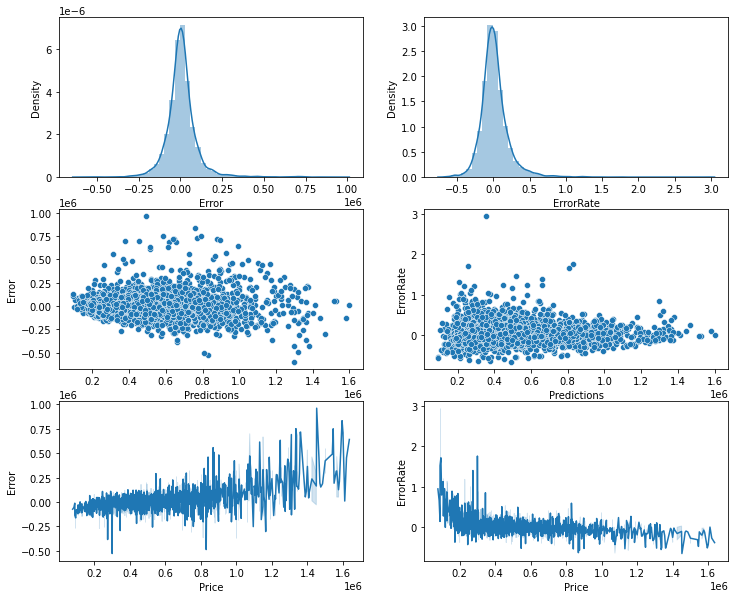

In [97]:
#Turning back to variable response
yhat_rfr_tuned=pd.DataFrame(data=yhat_xgb_tuned,columns=['Predictions'])
aux=pd.concat([x_test.reset_index(),y_test.reset_index(),yhat_rfr_tuned],axis=1)
aux['Price']=np.expm1(aux['Price'])
aux['Predictions']=np.expm1(aux['Predictions'])

#Error and ErrorRate
aux['Error']=aux['Price']-aux['Predictions']
aux['ErrorRate']=(aux['Predictions']/aux['Price'])-1

#Distplot
plt.subplot(3,2,1)
ax=sns.distplot(aux['Error'])
ax.figure.set_size_inches(12,10)

plt.subplot(3,2,2)
ax=sns.distplot(aux['ErrorRate'])

#Scatterplot
plt.subplot(3,2,3)
ax=sns.scatterplot(aux['Predictions'],aux['Error'])

plt.subplot(3,2,4)
ax=sns.scatterplot(aux['Predictions'],aux['ErrorRate'])

#Lineplot
plt.subplot(3,2,5)
ax=sns.lineplot(x='Price',y='Error',data=aux)

plt.subplot(3,2,6)
ax=sns.lineplot(x='Price',y='ErrorRate',data=aux)

# 10.0. DEPLOY MODEL TO PRODUCTION

##10.1. transformations class

In [98]:
'''import pandas as pd
import numpy  as np
import pickle
import inflection


class transformations (object):  
  def __init__(self):
    self.SqftAbove=                     pickle.load(open('parameters/SqftAbove_scaler.pkl','rb'))
    self.YrBuilt=                       pickle.load(open('parameters/YrBuilt_scaler.pkl','rb'))  
    self.SqftLiving=                    pickle.load(open('parameters/SqftLiving_scaler.pkl','rb'))   
    self.TimeOfExistence=               pickle.load(open('parameters/TimeOfExistence_scaler.pkl','rb'))  
    self.SqftLot=                       pickle.load(open('parameters/SqftLot_scaler.pkl','rb'))  
    self.LivingRoomIncrease=            pickle.load(open('parameters/LivingRoomIncrease_scaler.pkl','rb'))
    self.IncreaseInLotArea=             pickle.load(open('parameters/IncreaseInLotArea_scaler.pkl','rb'))    
    self.Lat=                           pickle.load(open('parameters/Lat_scaler.pkl','rb'))   
    self.Long=                          pickle.load(open('parameters/Long_scaler.pkl','rb')) 
    self.Zipcode=                       pickle.load(open('parameters/Zipcode_scaler.pkl','rb')) 
    self.SqftLiving15=                  pickle.load(open('parameters/SqftLiving15_scaler.pkl','rb')) 
    self.SqftLot15=                     pickle.load(open('parameters/SqftLot15_scaler.pkl','rb'))          
    
  
   

  def data_cleaning(self,data):    
    #Rename  
    columns={  'id':'Id', 'date':'Date', 'bedrooms':'Bedrooms',
               'bathrooms':'Bathrooms', 'sqft_living':'SqftLiving',
               'sqft_lot':'SqftLot','floors':'Floors','waterfront':'Waterfront',
               'view':'View', 'condition':'Condition', 'grade':'Grade',
               'sqft_above':'SqftAbove','sqft_basement':'SqftBasement',
               'yr_built':'YrBuilt', 'yr_renovated':'YrRenovated',
               'zipcode':'Zipcode', 'lat':'Lat', 'long':'Long',
               'sqft_living15':'SqftLiving15', 'sqft_lot15':'SqftLot15'}
    data=data.rename(columns=columns)

    #Change types
    serie=['Condition','Grade','Id','Waterfront']
    data[serie]=data[serie].astype(str)

    data['Date']=                  pd.to_datetime(data['Date'])
    return data
      


  def feature_engeneering(self,data):
    #turning square feet into square meters
    aux=['SqftLiving','SqftLot','SqftAbove','SqftBasement','SqftLiving15','SqftLot15']
    data[aux]=data[aux]*0.0929

    #YearOfAssessment
    data['YearOfAssessment']=data['Date'].dt.year

    #EvaluationMonth
    data['EvaluationMonth']=data['Date'].dt.month

    #TimeOfExistence'
    data['TimeOfExistence']=data['YearOfAssessment']-data['YrBuilt']

    #RetirementTime
    data['RetirementTime']=data['YearOfAssessment']-data['YrRenovated']

    #Grade
    data['Grade']=data['Grade'].apply(lambda x:
                                    
                                    '1' if x=='1'  else '1' if x=='2'  else '1' if x=='3' else '1' if x=='4' else
                                    '2' if x=='5'  else '2' if x=='6'  else '2' if x=='7' else
                                    '3' if x=='8'  else '3' if x=='9'  else '3' if x=='10'else
                                    '4' if x=='11' else '4' if x=='12' else '4' if x=='13'else

                                    'no_group')

    #Waterfront
    data['Waterfront']=data['Waterfront'].apply(lambda x:'yes' if x=='1'  else 'no')  
           
    #LivingRoomIncrease
    data['LivingRoomIncrease']=data['SqftLiving15']-data['SqftLiving']

    #IncreaseInLotArea
    data['IncreaseInLotArea']=data['SqftLot15']-data['SqftLot']   
    

    return data
      

  def data_preparation(self,data):  
       
    #SqftLiving
    data['SqftLiving']=self.SqftLiving.fit_transform(data[['SqftLiving']].values)      

    #SqftAbove
    data['SqftAbove']=self.SqftAbove.fit_transform(data[['SqftAbove']].values) 

    #TimeOfExistence
    data['TimeOfExistence']=self.TimeOfExistence.fit_transform(data[['TimeOfExistence']].values)    

    #SqftLot
    data['SqftLot']=self.SqftLot.fit_transform(data[['SqftLot']].values)

    #LivingRoomIncrease
    data['LivingRoomIncrease']=self.LivingRoomIncrease.fit_transform(data[['LivingRoomIncrease']].values)

    #IncreaseInLotArea
    data['IncreaseInLotArea']=self.IncreaseInLotArea.fit_transform(data[['IncreaseInLotArea']].values)  

    #Lat
    data['Lat']=self.Lat.fit_transform(data[['Lat']].values)  

    #Long
    data['Long']=self.Long.fit_transform(data[['Long']].values) 

    #YrBuilt
    data['YrBuilt']=self.YrBuilt.fit_transform(data[['YrBuilt']].values) 
     
    #Zipcode
    data['Zipcode']=self.Zipcode.fit_transform(data['Zipcode'])    
    
    #Grade
    a=0.06
    assortment_dict={'1':1*a,'2':2*a,'3':3*a,'4':4*a,'5':5*a,'6':6*a,'7':7*a,'8':8*a,'9':9*a,'10':10*a,'11':11*a,'12':12*a,'13':13*a}
    data['Grade']=data['Grade'].map(assortment_dict) 
        

    return data[[ 'SqftLiving','SqftLot', 'Grade','SqftAbove',
                  'YrBuilt','Zipcode','Lat','Long','SqftLiving15',
                  'SqftLot15','TimeOfExistence','LivingRoomIncrease',
                  'IncreaseInLotArea']]


  def get_prediction(self, model, dado_original, data_transforme):

    #prediction
    pred=model.predict(data_transforme)

    #join pred into the original data
    dado_original['Predictions']=np.expm1(pred)    

    return dado_original.to_json(orient='records',date_format='iso')'''

"import pandas as pd\nimport numpy  as np\nimport pickle\nimport inflection\n\n\nclass transformations (object):  \n  def __init__(self):\n    self.SqftAbove=                     pickle.load(open('parameters/SqftAbove_scaler.pkl','rb'))\n    self.YrBuilt=                       pickle.load(open('parameters/YrBuilt_scaler.pkl','rb'))  \n    self.SqftLiving=                    pickle.load(open('parameters/SqftLiving_scaler.pkl','rb'))   \n    self.TimeOfExistence=               pickle.load(open('parameters/TimeOfExistence_scaler.pkl','rb'))  \n    self.SqftLot=                       pickle.load(open('parameters/SqftLot_scaler.pkl','rb'))  \n    self.LivingRoomIncrease=            pickle.load(open('parameters/LivingRoomIncrease_scaler.pkl','rb'))\n    self.IncreaseInLotArea=             pickle.load(open('parameters/IncreaseInLotArea_scaler.pkl','rb'))    \n    self.Lat=                           pickle.load(open('parameters/Lat_scaler.pkl','rb'))   \n    self.Long=                         

## 10.2. API Handler

In [99]:
'''from flask                           import Flask,request,Response
from transformations.transformations import transformations
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/model_xgb_tuned_train.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #Isntantiate transformations
    pipeline=transformations()  

    #data cleaning
    df1=pipeline.data_cleaning(test_raw)  

    #feature engeneering
    df2=pipeline.feature_engeneering(df1)

    #data preparation
    df3=pipeline.data_preparation(df2)

    #predict
    df_response=pipeline.get_prediction(model,test_raw,df3)
    
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                           import Flask,request,Response\nfrom transformations.transformations import transformations\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/model_xgb_tuned_train.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      test_raw=pd.DataFrame(test_json,index=[0])\n\n    else:\n      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())\n    \n    #Isntantiate transformations\n    pipeline=transformations()  \n\n    #data cleaning\n    df1=pipeline.data_cleaning(test_raw)  \n\n    #feature engeneering\n    df2=pipeline.feature_engeneering(df1)\n\n    #data preparation\n    df3=pipeline.data_preparation(df2)\n\n    #predict\n    df_response=pipeline.get_prediction(model,test_raw,df3)\n    \n    return df_response\n\n  else:

## 10.3. API Tester

In [100]:
#Converter in json
dataset_deploy=dataset_deploy.head(10)
dataset_deploy=json.dumps(dataset_deploy.to_dict(orient='records'))

#API call
url='https://precimo9.herokuapp.com/oi'
headers={'content-type':'application/json'}
r=requests.post(url,data=dataset_deploy,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [101]:
#Predictions
df=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df

id             date  ...  sqft_lot15  Predictions
0   993002225  20140623T000000  ...        1470   669086.750
1  9530100921  20141027T000000  ...        3185   533778.688
2  3235390100  20150203T000000  ...        8961   465605.875
3  5122400025  20140708T000000  ...       16401   391940.969
4  9297300750  20141105T000000  ...        4800   506139.781
5  3856900590  20140806T000000  ...        4000  1546760.125
6  4024700100  20150121T000000  ...        8433   351821.688
7   114100131  20150114T000000  ...        8193   564801.375
8  2296700330  20141014T000000  ...        7961   597675.625
9  1995200215  20140826T000000  ...        6038   844789.500

[10 rows x 21 columns]